Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
 97% 1.76G/1.83G [00:12<00:01, 40.5MB/s]
100% 1.83G/1.83G [00:12<00:00, 162MB/s] 
anno_test.csv	kaggle.json  stanford-car-dataset-by-classes-folder.zip
anno_train.csv	names.csv
car_data	sample_data
Mounted at /content/drive
Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │       100,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,737,348 (94.37 MB)

 Trainable params: 1,149,636 (4.39 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.0130 - loss: 5.4066

207/207 ━━━━━━━━━━━━━━━━━━━━ 153s 665ms/step - accuracy: 0.0130 - loss: 5.4056 - val_accuracy: 0.0498 - val_loss: 4.7707
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.0497 - loss: 4.6647

207/207 ━━━━━━━━━━━━━━━━━━━━ 123s 595ms/step - accuracy: 0.0497 - loss: 4.6642 - val_accuracy: 0.0990 - val_loss: 4.1641
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.0876 - loss: 4.1817

207/207 ━━━━━━━━━━━━━━━━━━━━ 145s 613ms/step - accuracy: 0.0876 - loss: 4.1815 - val_accuracy: 0.1268 - val_loss: 3.8251
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.1238 - loss: 3.8679

207/207 ━━━━━━━━━━━━━━━━━━━━ 127s 613ms/step - accuracy: 0.1238 - loss: 3.8678 - val_accuracy: 0.1527 - val_loss: 3.6309
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.1503 - loss: 3.6775

207/207 ━━━━━━━━━━━━━━━━━━━━ 125s 603ms/step - accuracy: 0.1503 - loss: 3.6774 - val_accuracy: 0.1882 - val_loss: 3.4736
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.1807 - loss: 3.4886

207/207 ━━━━━━━━━━━━━━━━━━━━ 124s 601ms/step - accuracy: 0.1807 - loss: 3.4886 - val_accuracy: 0.2122 - val_loss: 3.3329
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.2037 - loss: 3.3538

207/207 ━━━━━━━━━━━━━━━━━━━━ 125s 602ms/step - accuracy: 0.2037 - loss: 3.3537 - val_accuracy: 0.2354 - val_loss: 3.1992
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.2091 - loss: 3.2556

207/207 ━━━━━━━━━━━━━━━━━━━━ 128s 617ms/step - accuracy: 0.2091 - loss: 3.2556 - val_accuracy: 0.2490 - val_loss: 3.0885
Epoch 9/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 127s 615ms/step - accuracy: 0.2268 - loss: 3.1495 - val_accuracy: 0.2458 - val_loss: 3.0940
Epoch 10/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.2375 - loss: 3.0775

207/207 ━━━━━━━━━━━━━━━━━━━━ 146s 705ms/step - accuracy: 0.2375 - loss: 3.0776 - val_accuracy: 0.2529 - val_loss: 3.0656
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.1555 - loss: 3.7831

207/207 ━━━━━━━━━━━━━━━━━━━━ 234s 832ms/step - accuracy: 0.1557 - loss: 3.7817 - val_accuracy: 0.2665 - val_loss: 2.9602
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.2639 - loss: 2.9887

207/207 ━━━━━━━━━━━━━━━━━━━━ 144s 695ms/step - accuracy: 0.2639 - loss: 2.9885 - val_accuracy: 0.2943 - val_loss: 2.7660
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.2983 - loss: 2.7493

207/207 ━━━━━━━━━━━━━━━━━━━━ 204s 708ms/step - accuracy: 0.2983 - loss: 2.7492 - val_accuracy: 0.3325 - val_loss: 2.6043
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.3417 - loss: 2.5228

207/207 ━━━━━━━━━━━━━━━━━━━━ 152s 732ms/step - accuracy: 0.3416 - loss: 2.5228 - val_accuracy: 0.3499 - val_loss: 2.5019
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.3684 - loss: 2.3607

207/207 ━━━━━━━━━━━━━━━━━━━━ 153s 738ms/step - accuracy: 0.3684 - loss: 2.3607 - val_accuracy: 0.3713 - val_loss: 2.3918
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.3843 - loss: 2.3175

207/207 ━━━━━━━━━━━━━━━━━━━━ 152s 732ms/step - accuracy: 0.3843 - loss: 2.3173 - val_accuracy: 0.3797 - val_loss: 2.2891
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.4049 - loss: 2.2131

207/207 ━━━━━━━━━━━━━━━━━━━━ 149s 719ms/step - accuracy: 0.4050 - loss: 2.2129 - val_accuracy: 0.3997 - val_loss: 2.2475
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4339 - loss: 2.0654

207/207 ━━━━━━━━━━━━━━━━━━━━ 151s 730ms/step - accuracy: 0.4339 - loss: 2.0655 - val_accuracy: 0.4198 - val_loss: 2.1546
Epoch 9/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.4385 - loss: 2.0304

207/207 ━━━━━━━━━━━━━━━━━━━━ 151s 728ms/step - accuracy: 0.4386 - loss: 2.0303 - val_accuracy: 0.4379 - val_loss: 2.1121
Epoch 10/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.4706 - loss: 1.9487

207/207 ━━━━━━━━━━━━━━━━━━━━ 152s 733ms/step - accuracy: 0.4706 - loss: 1.9485 - val_accuracy: 0.4502 - val_loss: 2.0612


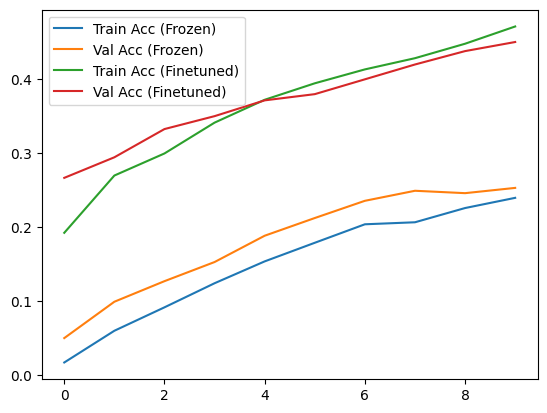

252/252 ━━━━━━━━━━━━━━━━━━━━ 49s 193ms/step - accuracy: 0.4480 - loss: 2.0463


Test Accuracy after fine-tuning: 48.13%
✅ Final model saved to: /content/drive/MyDrive/stanford_car_resnet50_model_final.h5


In [ ]:
# ===============================
# 🚀 STEP 0: SETUP
# ===============================

# Install Kaggle CLI if not installed
!pip install -q kaggle

# Upload kaggle.json to authenticate Kaggle API
from google.colab import files
files.upload()

# Move kaggle.json to correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ===============================
# 🚀 STEP 1: DOWNLOAD & UNZIP DATASET
# ===============================

# Download Stanford Cars dataset (by classes folder)
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

# Unzip
!unzip -q stanford-car-dataset-by-classes-folder.zip

# Check contents
!ls

# ===============================
# 🚀 STEP 2: IMPORT LIBRARIES
# ===============================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 🚀 STEP 3: MOUNT GOOGLE DRIVE
# ===============================

from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 🚀 STEP 4: DATA GENERATORS
# ===============================

train_dir = '/content/car_data/car_data/train'
test_dir = '/content/car_data/car_data/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ===============================
# 🚀 STEP 5: BUILD MODEL (RESNET50)
# ===============================

base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ===============================
# 🚀 STEP 6: TRAIN MODEL (FROZEN BASE)
# ===============================

# Define callbacks to save model to Google Drive
checkpoint_path_frozen = '/content/drive/MyDrive/stanford_car_resnet50_model_frozen.h5'

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_frozen,
                                                monitor='val_loss',
                                                save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

# ===============================
# 🚀 STEP 7: FINE-TUNE MODEL
# ===============================

# Unfreeze base model for fine-tuning
base_model.trainable = True

# Compile with lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define fine-tuning checkpoint path on Drive
checkpoint_path_finetuned = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned.h5'

checkpoint_ft = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_finetuned,
                                                   monitor='val_loss',
                                                   save_best_only=True)

history_ft = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint_ft]
)

# ===============================
# 🚀 STEP 8: PLOT TRAINING CURVES
# ===============================

plt.plot(history.history['accuracy'], label='Train Acc (Frozen)')
plt.plot(history.history['val_accuracy'], label='Val Acc (Frozen)')
plt.plot(history_ft.history['accuracy'], label='Train Acc (Finetuned)')
plt.plot(history_ft.history['val_accuracy'], label='Val Acc (Finetuned)')
plt.legend()
plt.show()

# ===============================
# 🚀 STEP 9: EVALUATE FINAL MODEL
# ===============================

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy after fine-tuning: {test_acc*100:.2f}%")

# ===============================
# 🚀 STEP 10: SAVE FINAL MODEL TO DRIVE (OPTIONAL)
# ===============================

final_model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_final.h5'
model.save(final_model_path)

print(f"✅ Final model saved to: {final_model_path}")


In [ ]:
# ===============================
# 🚀 FIX: ENSURE DATASET FOLDERS EXIST
# ===============================

import os

# Check if folder exists, if not, download and unzip
if not os.path.exists('/content/car_data/car_data/train'):
    print("🔄 Dataset not found. Downloading and unzipping...")

    # Install Kaggle if needed
    !pip install -q kaggle

    # Authenticate Kaggle
    from google.colab import files
    files.upload()  # Upload kaggle.json again if needed

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download dataset
    !kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

    # Unzip dataset
    !unzip -q stanford-car-dataset-by-classes-folder.zip

    print("✅ Dataset ready.")
else:
    print("✅ Dataset folder already exists.")


🔄 Dataset not found. Downloading and unzipping...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
100% 1.82G/1.83G [00:13<00:00, 239MB/s]
100% 1.83G/1.83G [00:13<00:00, 150MB/s]
✅ Dataset ready.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)
replace anno_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │       100,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,737,350 (94.37 MB)

 Trainable params: 24,684,228 (94.16 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.4815 - loss: 1.8832

207/207 ━━━━━━━━━━━━━━━━━━━━ 242s 872ms/step - accuracy: 0.4815 - loss: 1.8832 - val_accuracy: 0.4690 - val_loss: 1.9814
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.4892 - loss: 1.8208

207/207 ━━━━━━━━━━━━━━━━━━━━ 149s 720ms/step - accuracy: 0.4892 - loss: 1.8207 - val_accuracy: 0.4877 - val_loss: 1.9416
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5009 - loss: 1.7516

207/207 ━━━━━━━━━━━━━━━━━━━━ 150s 725ms/step - accuracy: 0.5010 - loss: 1.7515 - val_accuracy: 0.4890 - val_loss: 1.8874
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5115 - loss: 1.6653

207/207 ━━━━━━━━━━━━━━━━━━━━ 150s 726ms/step - accuracy: 0.5115 - loss: 1.6652 - val_accuracy: 0.4942 - val_loss: 1.8415
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5235 - loss: 1.6632

207/207 ━━━━━━━━━━━━━━━━━━━━ 153s 739ms/step - accuracy: 0.5236 - loss: 1.6630 - val_accuracy: 0.5052 - val_loss: 1.8197
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5581 - loss: 1.5247

207/207 ━━━━━━━━━━━━━━━━━━━━ 196s 711ms/step - accuracy: 0.5581 - loss: 1.5248 - val_accuracy: 0.5162 - val_loss: 1.7794
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5671 - loss: 1.5078

207/207 ━━━━━━━━━━━━━━━━━━━━ 152s 734ms/step - accuracy: 0.5670 - loss: 1.5078 - val_accuracy: 0.5278 - val_loss: 1.7393
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5770 - loss: 1.4225

207/207 ━━━━━━━━━━━━━━━━━━━━ 153s 736ms/step - accuracy: 0.5769 - loss: 1.4226 - val_accuracy: 0.5362 - val_loss: 1.7227
Epoch 9/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.5996 - loss: 1.3773

207/207 ━━━━━━━━━━━━━━━━━━━━ 196s 707ms/step - accuracy: 0.5997 - loss: 1.3773 - val_accuracy: 0.5453 - val_loss: 1.6944
Epoch 10/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6089 - loss: 1.3293

207/207 ━━━━━━━━━━━━━━━━━━━━ 153s 739ms/step - accuracy: 0.6089 - loss: 1.3293 - val_accuracy: 0.5492 - val_loss: 1.6811


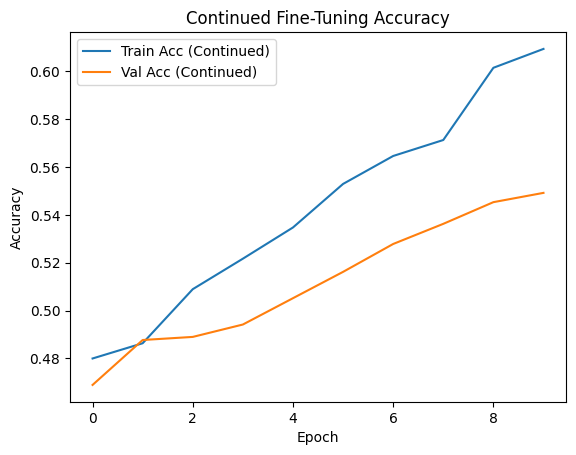

252/252 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - accuracy: 0.5356 - loss: 1.7105
✅ Test Accuracy after continued fine-tuning: 57.84%


In [ ]:
# ===============================
# 🚀 CONTINUATION TRAINING CODE
# ===============================

# 🔷 Install Kaggle (if not already installed)
!pip install -q kaggle

# 🔷 Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 🔷 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 🚀 RELOAD DATASET
# ===============================

# Download dataset if not already in session
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
!unzip -q stanford-car-dataset-by-classes-folder.zip

# ===============================
# 🚀 DATA GENERATORS
# ===============================

train_dir = '/content/car_data/car_data/train'
test_dir = '/content/car_data/car_data/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ===============================
# 🚀 LOAD SAVED FINETUNED MODEL
# ===============================

model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned.h5'  # adjust if your path differs
model = load_model(model_path)
model.summary()

# ===============================
# 🚀 PREPARE FOR CONTINUED TRAINING
# ===============================

# Ensure base model is trainable
base_model = model.layers[0]
base_model.trainable = True

# Compile with low learning rate for continued fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ===============================
# 🚀 CONTINUE TRAINING
# ===============================

checkpoint_path_continue = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued.h5'

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_continue,
                                                monitor='val_loss',
                                                save_best_only=True)

history_continue = model.fit(
    train_generator,
    epochs=10,  # adjust as needed
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

# ===============================
# 🚀 PLOT CONTINUED TRAINING CURVES
# ===============================

plt.plot(history_continue.history['accuracy'], label='Train Acc (Continued)')
plt.plot(history_continue.history['val_accuracy'], label='Val Acc (Continued)')
plt.title('Continued Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ===============================
# 🚀 FINAL EVALUATION
# ===============================

test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after continued fine-tuning: {test_acc*100:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Dataset not found. Downloading and unzipping...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
 98% 1.79G/1.83G [00:17<00:00, 35.3MB/s]
100% 1.83G/1.83G [00:17<00:00, 115MB/s] 
✅ Dataset ready.
Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │       100,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,737,350 (94.37 MB)

 Trainable params: 24,684,228 (94.16 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.6177 - loss: 1.2910

207/207 ━━━━━━━━━━━━━━━━━━━━ 251s 912ms/step - accuracy: 0.6177 - loss: 1.2910 - val_accuracy: 0.5614 - val_loss: 1.6317
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6402 - loss: 1.2384

207/207 ━━━━━━━━━━━━━━━━━━━━ 165s 798ms/step - accuracy: 0.6402 - loss: 1.2385 - val_accuracy: 0.5666 - val_loss: 1.5984
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 160s 770ms/step - accuracy: 0.6506 - loss: 1.2012 - val_accuracy: 0.5634 - val_loss: 1.6272
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.6385 - loss: 1.1883

207/207 ━━━━━━━━━━━━━━━━━━━━ 161s 779ms/step - accuracy: 0.6386 - loss: 1.1881 - val_accuracy: 0.5724 - val_loss: 1.5776
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.6724 - loss: 1.0903

207/207 ━━━━━━━━━━━━━━━━━━━━ 167s 808ms/step - accuracy: 0.6724 - loss: 1.0904 - val_accuracy: 0.5925 - val_loss: 1.5499
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.6826 - loss: 1.0636

207/207 ━━━━━━━━━━━━━━━━━━━━ 165s 796ms/step - accuracy: 0.6826 - loss: 1.0636 - val_accuracy: 0.5789 - val_loss: 1.5439
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 192s 747ms/step - accuracy: 0.6884 - loss: 1.0391 - val_accuracy: 0.5854 - val_loss: 1.5443
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6908 - loss: 1.0122

207/207 ━━━━━━━━━━━━━━━━━━━━ 164s 795ms/step - accuracy: 0.6908 - loss: 1.0123 - val_accuracy: 0.6035 - val_loss: 1.5169
Epoch 9/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.6932 - loss: 1.0032

207/207 ━━━━━━━━━━━━━━━━━━━━ 202s 796ms/step - accuracy: 0.6932 - loss: 1.0032 - val_accuracy: 0.6041 - val_loss: 1.4834
Epoch 10/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.7282 - loss: 0.9208

207/207 ━━━━━━━━━━━━━━━━━━━━ 200s 785ms/step - accuracy: 0.7281 - loss: 0.9209 - val_accuracy: 0.6074 - val_loss: 1.4386
Epoch 11/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7132 - loss: 0.9471

207/207 ━━━━━━━━━━━━━━━━━━━━ 167s 808ms/step - accuracy: 0.7132 - loss: 0.9469 - val_accuracy: 0.6113 - val_loss: 1.4375
Epoch 12/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 160s 772ms/step - accuracy: 0.7337 - loss: 0.8585 - val_accuracy: 0.6235 - val_loss: 1.4566
Epoch 13/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7483 - loss: 0.8496

207/207 ━━━━━━━━━━━━━━━━━━━━ 162s 784ms/step - accuracy: 0.7482 - loss: 0.8496 - val_accuracy: 0.6177 - val_loss: 1.4083
Epoch 14/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7506 - loss: 0.8444

207/207 ━━━━━━━━━━━━━━━━━━━━ 198s 764ms/step - accuracy: 0.7506 - loss: 0.8444 - val_accuracy: 0.6100 - val_loss: 1.4025
Epoch 15/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 155s 747ms/step - accuracy: 0.7675 - loss: 0.7762 - val_accuracy: 0.6158 - val_loss: 1.4097
Epoch 16/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 170s 821ms/step - accuracy: 0.7533 - loss: 0.7964 - val_accuracy: 0.6203 - val_loss: 1.4073
Epoch 17/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.7595 - loss: 0.7489

207/207 ━━━━━━━━━━━━━━━━━━━━ 163s 785ms/step - accuracy: 0.7596 - loss: 0.7489 - val_accuracy: 0.6358 - val_loss: 1.3923
Epoch 18/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.7811 - loss: 0.7129

207/207 ━━━━━━━━━━━━━━━━━━━━ 163s 788ms/step - accuracy: 0.7811 - loss: 0.7129 - val_accuracy: 0.6332 - val_loss: 1.3865
Epoch 19/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7916 - loss: 0.6938

207/207 ━━━━━━━━━━━━━━━━━━━━ 161s 775ms/step - accuracy: 0.7916 - loss: 0.6938 - val_accuracy: 0.6391 - val_loss: 1.3534
Epoch 20/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.7942 - loss: 0.6745

207/207 ━━━━━━━━━━━━━━━━━━━━ 162s 782ms/step - accuracy: 0.7942 - loss: 0.6745 - val_accuracy: 0.6442 - val_loss: 1.3516


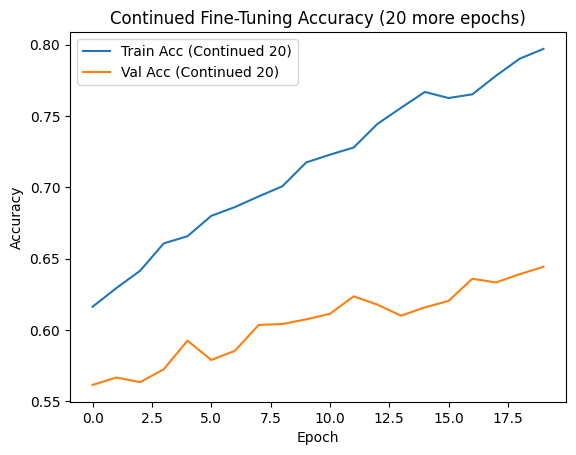

252/252 ━━━━━━━━━━━━━━━━━━━━ 57s 225ms/step - accuracy: 0.6256 - loss: 1.4088
✅ Test Accuracy after additional 20 epochs: 66.55%


In [ ]:
# ===============================
# 🚀 CONTINUE TRAINING FOR 20 MORE EPOCHS (FULL SAFE VERSION)
# ===============================

# 🔷 Install Kaggle if needed
!pip install -q kaggle

# 🔷 Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# ===============================
# 🚀 MOUNT GOOGLE DRIVE
# ===============================

from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 🚀 ENSURE DATASET IS AVAILABLE
# ===============================

# Check if dataset exists, if not, download and unzip
if not os.path.exists('/content/car_data/car_data/train'):
    print("🔄 Dataset not found. Downloading and unzipping...")

    # Upload kaggle.json if needed
    from google.colab import files
    files.upload()

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download dataset
    !kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
    !unzip -q stanford-car-dataset-by-classes-folder.zip

    print("✅ Dataset ready.")
else:
    print("✅ Dataset already exists.")

# ===============================
# 🚀 DATA GENERATORS
# ===============================

train_dir = '/content/car_data/car_data/train'
test_dir = '/content/car_data/car_data/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ===============================
# 🚀 LOAD YOUR LAST SAVED MODEL
# ===============================

model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued.h5'
model = load_model(model_path)
model.summary()

# ===============================
# 🚀 ENSURE BASE MODEL IS TRAINABLE
# ===============================

base_model = model.layers[0]
base_model.trainable = True

# Re-compile with low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ===============================
# 🚀 DEFINE CHECKPOINT & EARLY STOPPING
# ===============================

checkpoint_path_continue_20 = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5'

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_continue_20,
                                                monitor='val_loss',
                                                save_best_only=True)

# ===============================
# 🚀 TRAIN FOR 20 MORE EPOCHS
# ===============================

history_continue = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

# ===============================
# 🚀 PLOT TRAINING CURVES
# ===============================

plt.plot(history_continue.history['accuracy'], label='Train Acc (Continued 20)')
plt.plot(history_continue.history['val_accuracy'], label='Val Acc (Continued 20)')
plt.title('Continued Fine-Tuning Accuracy (20 more epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ===============================
# 🚀 FINAL EVALUATION
# ===============================

test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after additional 20 epochs: {test_acc*100:.2f}%")


In [ ]:
# ================================
# 🔧 Stanford Cars MMC Inference +
# 🔢 Manual Accuracy Evaluation
# ================================

# 1. Install requirements
!pip install -q tensorflow

# 2. Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from google.colab import drive, files
from PIL import Image
import os

# 3. Mount Google Drive
drive.mount('/content/drive')

# 4. Load your trained model
model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5'
model = tf.keras.models.load_model(model_path)
print(f"✅ Model loaded from: {model_path}")

# 5. Load class labels (based on your training data)
# Update this if your dataset structure is different
train_dir = '/content/car_data/car_data/train'  # Change if needed

datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
generator = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=1, class_mode='categorical')
class_indices = generator.class_indices
class_labels = list(class_indices.keys())
print("✅ Class labels loaded.")

# 6. Upload multiple images
uploaded = files.upload()
image_filenames = list(uploaded.keys())

# 7. Predict each image and optionally collect accuracy
correct = 0
total = 0

# 🔁 Optional: Map your uploaded image filenames to their correct class (ground truth)
# Example: {'car1.jpg': 'Aston Martin DB9 Coupe 2012', ...}
ground_truth = {
    'img1.jpg': 'Aston Martin DB9 Coupe 2012',
    'img2.jpg': 'Honda Accord Sedan 2012',
    'img3.jpg': 'Tesla Model S 2012'
    # 👆 Replace with your actual uploaded image filenames and true labels
}

for filename in image_filenames:
    # Load and preprocess image
    img = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_class_index = np.argmax(preds)
    confidence = np.max(preds) * 100
    predicted_label = class_labels[pred_class_index]

    # Print result
    print(f"\n🖼️ Image: {filename}")
    print(f"🔍 Predicted: {predicted_label} ({confidence:.2f}%)")

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
    plt.show()

    # Check against ground truth (if provided)
    if filename in ground_truth:
        actual_label = ground_truth[filename]
        total += 1
        if predicted_label == actual_label:
            correct += 1
        else:
            print(f"❌ Wrong! Actual: {actual_label}")

# 8. Print final accuracy
if total > 0:
    acc = (correct / total) * 100
    print(f"\n✅ Accuracy on uploaded images: {acc:.2f}% ({correct}/{total})")
else:
    print("\n⚠️ No ground truth provided. Accuracy not calculated.")


Mounted at /content/drive


✅ Model loaded from: /content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5


FileNotFoundError: [Errno 2] No such file or directory: '/content/car_data/car_data/train'

In [ ]:
# ===============================
# 🚀 IMPORT LIBRARIES
# ===============================
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ===============================
# 🚀 LOAD MODEL
# ===============================
model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5'
model = load_model(model_path)
model.summary()

# ===============================
# 🚀 LOAD LABELS (CLASS INDICES)
# ===============================
# Assuming your test set structure is still present
test_dir = '/content/car_data/car_data/test'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# ===============================
# 🚀 EVALUATE ACCURACY
# ===============================
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

# ===============================
# 🚀 UPLOAD IMAGES FOR PREDICTION
# ===============================
uploaded = files.upload()

for fname in uploaded.keys():
    # Load and preprocess
    img_path = fname
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = idx_to_class[np.argmax(predictions)]

    # Plot
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"🚗 Predicted: {predicted_class}")
    plt.show()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# ===============================
# 🔹 INSTALL & IMPORTS
# ===============================
!pip install -q kaggle

import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ===============================
# 🔹 MOUNT GOOGLE DRIVE
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 🔹 DOWNLOAD & EXTRACT DATASET
# ===============================
if not os.path.exists("/content/car_data/car_data/train"):
    print("🔄 Downloading and extracting Stanford Cars dataset...")

    uploaded = files.upload()  # Upload your kaggle.json
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
    !unzip -q stanford-car-dataset-by-classes-folder.zip -d /content/car_data

    print("✅ Dataset downloaded and extracted to /content/car_data")
else:
    print("✅ Dataset already exists at /content/car_data")

# ===============================
# 🔹 LOAD CLASS LABELS
# ===============================
IMG_SIZE = (224, 224)

temp_datagen = ImageDataGenerator()
temp_generator = temp_datagen.flow_from_directory(
    '/content/car_data/car_data/train',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

class_indices = temp_generator.class_indices
class_labels = list(class_indices.keys())

print(f"✅ Loaded {len(class_labels)} class labels.")

# ===============================
# 🔹 LOAD MODEL FROM DRIVE
# ===============================
model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5'

model = load_model(model_path)
print("✅ Model loaded successfully.")
model.summary()

# ===============================
# 🔹 UPLOAD IMAGE(S) FOR PREDICTION
# ===============================
uploaded = files.upload()

for fname in uploaded.keys():
    # Load and preprocess image
    img_path = os.path.join("/content", fname)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_index]
    confidence = np.max(predictions)

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Downloading and extracting Stanford Cars dataset...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
100% 1.82G/1.83G [00:17<00:00, 249MB/s]
100% 1.83G/1.83G [00:17<00:00, 111MB/s]
✅ Dataset downloaded and extracted to /content/car_data


FileNotFoundError: [Errno 2] No such file or directory: '/content/car_data/car_data/train'

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

uploaded = files.upload()

for fname in uploaded.keys():
    img_path = os.path.join("/content", fname)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    preds = model.predict(img_array)
    top_index = np.argmax(preds)
    predicted_class = class_names[top_index]
    confidence = preds[0][top_index]

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()


Saving j.jpg to j.jpg


NameError: name 'model' is not defined

In [ ]:
# ===============================
# 🔹 INSTALL DEPENDENCIES
# ===============================
!pip install -q tensorflow matplotlib

import os
import numpy as np
import scipy.io
import shutil
import matplotlib.pyplot as plt
from google.colab import drive, files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# ===============================
# 🔹 MOUNT GOOGLE DRIVE
# ===============================
drive.mount('/content/drive')

# ===============================
# 🔹 DOWNLOAD & EXTRACT DATASET
# ===============================
import urllib.request
import tarfile

dataset_dir = "/content/stanford_cars"
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

if not os.path.exists(os.path.join(dataset_dir, "cars_train")):
    print("🔽 Downloading dataset...")
    urllib.request.urlretrieve(
        "http://ai.stanford.edu/~jkrause/car196/cars_train.tgz",
        os.path.join(dataset_dir, "cars_train.tgz")
    )
    urllib.request.urlretrieve(
        "http://ai.stanford.edu/~jkrause/car196/cars_test.tgz",
        os.path.join(dataset_dir, "cars_test.tgz")
    )
    urllib.request.urlretrieve(
        "http://ai.stanford.edu/~jkrause/car196/cars_train_annos.mat",
        os.path.join(dataset_dir, "cars_train_annos.mat")
    )
    urllib.request.urlretrieve(
        "http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat",
        os.path.join(dataset_dir, "cars_test_annos_withlabels.mat")
    )
    urllib.request.urlretrieve(
        "http://ai.stanford.edu/~jkrause/car196/cars_meta.mat",
        os.path.join(dataset_dir, "cars_meta.mat")
    )

    print("📦 Extracting...")
    with tarfile.open(os.path.join(dataset_dir, "cars_train.tgz")) as tar:
        tar.extractall(path=dataset_dir)
    with tarfile.open(os.path.join(dataset_dir, "cars_test.tgz")) as tar:
        tar.extractall(path=dataset_dir)

    print("✅ Downloaded and extracted Stanford Cars dataset")
else:
    print("✅ Dataset already downloaded.")

# ===============================
# 🔹 LOAD CLASS LABELS
# ===============================
meta = scipy.io.loadmat(os.path.join(dataset_dir, "cars_meta.mat"))
class_names = [x[0] for x in meta["class_names"][0]]
print(f"✅ Loaded {len(class_names)} classes.")

# ===============================
# 🔹 LOAD YOUR TRAINED MODEL
# ===============================
model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5'
model = load_model(model_path)
print("✅ Model loaded.")

# ===============================
# 🔹 UPLOAD & PREDICT
# ===============================
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = os.path.join("/content", fname)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    preds = model.predict(img_array)
    top_index = np.argmax(preds)
    predicted_class = class_names[top_index]
    confidence = preds[0][top_index]

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()


KeyboardInterrupt: 

Saving kaggle.json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)
replace anno_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
✅ Found 196 classes.
['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model loaded.
Upload image(s) to predict the make and model:


Saving j.jpg to j (2).jpg
Saving jj.jpg to jj (1).jpg

Processing j (2).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Make & Model: Porsche Panamera Sedan 2012
Confidence: 50.94%


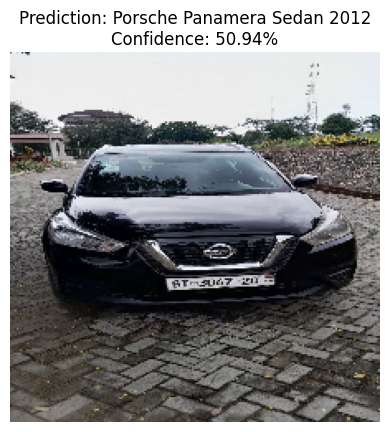


Processing jj (1).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Make & Model: Acura TL Sedan 2012
Confidence: 23.26%


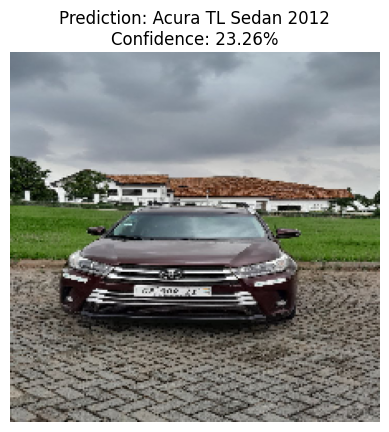

In [ ]:
# === Step 1: Setup Kaggle & Download Dataset ===
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload your kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Stanford Cars dataset
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

# Unzip dataset
!unzip -q stanford-car-dataset-by-classes-folder.zip

# === Step 2: Extract class names from train folder ===
import os

train_dir = '/content/car_data/car_data/train'
class_names = sorted(os.listdir(train_dir))
print(f"✅ Found {len(class_names)} classes.")
print(class_names[:10])  # show first 10 classes as example

# === Step 3: Load libraries & your model ===
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5'
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded.")

IMG_SIZE = (224, 224)

# === Step 4: Upload image(s) for prediction ===
print("Upload image(s) to predict the make and model:")
uploaded = files.upload()

for img_name in uploaded.keys():
    print(f"\nProcessing {img_name}...")

    # Load and preprocess image
    img = image.load_img(img_name, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_exp)

    # Predict
    preds = model.predict(img_preprocessed)
    pred_index = np.argmax(preds)
    pred_class = class_names[pred_index]
    confidence = preds[0][pred_index]

    # Print prediction and confidence
    print(f"Predicted Make & Model: {pred_class}")
    print(f"Confidence: {confidence * 100:.2f}%")

    # Display image with prediction
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}\nConfidence: {confidence*100:.2f}%")
    plt.axis('off')
    plt.show()


Saving images (3).jpeg to images (3).jpeg
Saving download (14).jpeg to download (14).jpeg
Saving download (13).jpeg to download (13).jpeg
Saving download (12).jpeg to download (12).jpeg
Saving download (11).jpeg to download (11) (1).jpeg

Processing: images (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Top 3 predictions:
Chrysler PT Cruiser Convertible 2008: 63.40%
Infiniti QX56 SUV 2011: 7.26%
Hyundai Genesis Sedan 2012: 6.93%


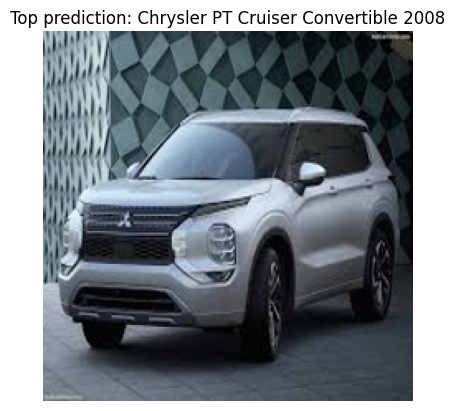


Processing: download (14).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Top 3 predictions:
Mercedes-Benz E-Class Sedan 2012: 44.74%
BMW X3 SUV 2012: 40.24%
BMW 3 Series Sedan 2012: 2.88%


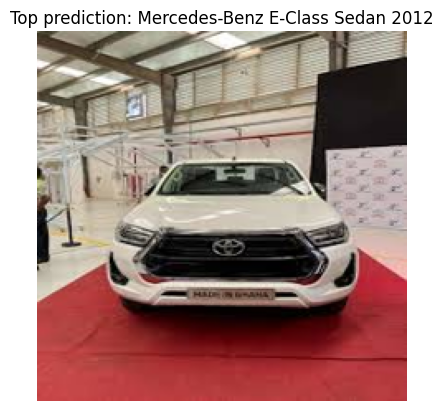


Processing: download (13).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Top 3 predictions:
Ford Fiesta Sedan 2012: 40.05%
Toyota Corolla Sedan 2012: 30.46%
Toyota Camry Sedan 2012: 19.44%


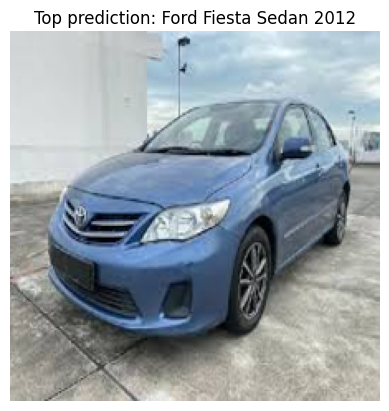


Processing: download (12).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Top 3 predictions:
Ford Edge SUV 2012: 26.32%
Chevrolet Traverse SUV 2012: 19.75%
Chevrolet Avalanche Crew Cab 2012: 14.07%


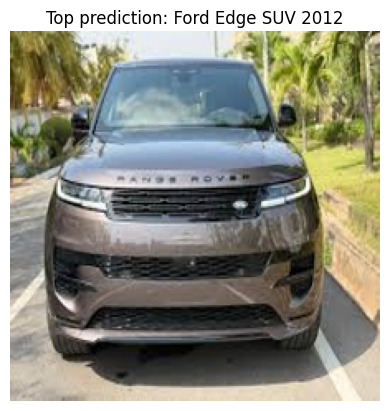


Processing: download (11) (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Top 3 predictions:
BMW Z4 Convertible 2012: 25.50%
Buick Regal GS 2012: 12.29%
BMW M3 Coupe 2012: 12.09%


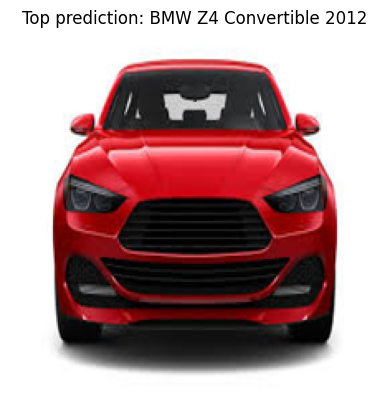

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from google.colab import files

# Upload multiple images
uploaded_files = files.upload()

for image_path in uploaded_files.keys():
    print(f"\nProcessing: {image_path}")

    # Load image and preprocess
    img = Image.open(image_path).convert('RGB').resize((224, 224))
    img_array = np.array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))  # Add batch dim

    # Predict
    preds = model.predict(img_preprocessed)

    # Get top 3 predictions
    top_k = 3
    top_indices = preds[0].argsort()[-top_k:][::-1]

    print("Top 3 predictions:")
    for i in top_indices:
        print(f"{class_names[i]}: {preds[0][i]*100:.2f}%")

    # Optional: display image with highest prediction label
    plt.imshow(img)
    plt.title(f"Top prediction: {class_names[top_indices[0]]}")
    plt.axis('off')
    plt.show()


In [ ]:
# --- convert_h5_to_pt_drive.py ---
import torch
from torchvision import models
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from google.colab import drive

# --- Step 0: Mount Google Drive ---
drive.mount('/content/drive')

# --- Step 1: Load Keras model from Drive ---
keras_model_path = "/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5"
keras_model = load_model(keras_model_path)
print("✅ Keras model loaded from Drive.")

# --- Step 2: Rebuild same ResNet50 architecture in PyTorch ---
num_classes = keras_model.output_shape[1]  # should be 196 for Cars196
pt_model = models.resnet50(pretrained=False)
pt_model.fc = torch.nn.Linear(pt_model.fc.in_features, num_classes)

# --- Step 3: Copy weights from Keras to PyTorch ---
# Function to copy weights layer by layer
keras_layers = [layer for layer in keras_model.layers if len(layer.get_weights()) > 0]

for layer in keras_layers:
    weights = layer.get_weights()
    if 'conv' in layer.name and len(weights) > 0:
        w = np.transpose(weights[0], (3, 2, 0, 1))
        pt_layer = dict(pt_model.named_modules()).get(layer.name)
        if pt_layer is not None:
            pt_layer.weight.data = torch.from_numpy(w).float()
        if len(weights) > 1:
            pt_layer.bias.data = torch.from_numpy(weights[1]).float()
    elif 'bn' in layer.name and len(weights) > 0:
        pt_layer = dict(pt_model.named_modules()).get(layer.name)
        if pt_layer is not None:
            pt_layer.weight.data = torch.from_numpy(weights[0]).float()
            pt_layer.bias.data = torch.from_numpy(weights[1]).float()
            pt_layer.running_mean = torch.from_numpy(weights[2]).float()
            pt_layer.running_var = torch.from_numpy(weights[3]).float()
    elif 'dense' in layer.name or 'fc' in layer.name:
        w, b = weights
        pt_model.fc.weight.data = torch.from_numpy(w.T).float()
        pt_model.fc.bias.data = torch.from_numpy(b).float()

print("✅ Weights copied to PyTorch model.")

# --- Step 4: Save PyTorch model back to Drive ---
pt_model_path = "/content/drive/MyDrive/stanford_car_resnet50_model_finetuned.pt"
torch.save(pt_model, pt_model_path)
print(f"✅ PyTorch model saved to Drive at {pt_model_path}")


Mounted at /content/drive


✅ Keras model loaded from Drive.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Weights copied to PyTorch model.
✅ PyTorch model saved to Drive at /content/drive/MyDrive/stanford_car_resnet50_model_finetuned.pt


In [ ]:
# ============================================
# 🚀 Convert Keras .h5 to TFLite and SAVE TO DRIVE
# ============================================
from google.colab import drive
import os, urllib.request, scipy.io
import tensorflow as tf

# ---- 1) Mount Google Drive ----
drive.mount('/content/drive', force_remount=True)

# ---- 2) Configure your paths (EDIT if your filenames/folders differ) ----
MODEL_H5 = '/content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5'
DRIVE_OUT_DIR = '/content/drive/MyDrive/exports_for_pi'   # output folder in Drive
CARS_META_URL = 'http://ai.stanford.edu/~jkrause/car196/cars_meta.mat'

# Create output directory in Drive
os.makedirs(DRIVE_OUT_DIR, exist_ok=True)

# ---- 3) Verify model exists on Drive ----
if not os.path.exists(MODEL_H5):
    raise FileNotFoundError(f"❌ Model .h5 not found at: {MODEL_H5}\n"
                            f"➡️  Update MODEL_H5 to the correct path in your Drive.")

print(f"✅ Found model: {MODEL_H5}")

# ---- 4) Ensure we have cars_meta.mat (for labels) ----
meta_local_path = '/content/cars_meta.mat'
if not os.path.exists(meta_local_path):
    print("📥 Downloading cars_meta.mat for class labels...")
    urllib.request.urlretrieve(CARS_META_URL, meta_local_path)
else:
    print("✅ cars_meta.mat already present locally")

# ---- 5) Build labels.txt directly in Drive ----
meta = scipy.io.loadmat(meta_local_path)
class_names = [x[0] for x in meta["class_names"][0]]

labels_drive_path = os.path.join(DRIVE_OUT_DIR, 'labels.txt')
with open(labels_drive_path, 'w') as f:
    f.writelines(name + '\n' for name in class_names)

print(f"✅ Saved labels.txt to Drive: {labels_drive_path}")

# ---- 6) Load .h5 and convert to TFLite (float model; optimized) ----
print("📦 Loading Keras model...")
model = tf.keras.models.load_model(MODEL_H5)

print("🔄 Converting to TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Keeps float precision; applies graph/transformation optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# ---- 7) Save TFLite directly to Drive ----
tflite_drive_path = os.path.join(DRIVE_OUT_DIR, 'cars_model.tflite')
with open(tflite_drive_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ Saved TFLite model to Drive: {tflite_drive_path}")

print("\n🎯 DONE! Files in Drive:")
print(f"   • {tflite_drive_path}")
print(f"   • {labels_drive_path}")


Mounted at /content/drive
✅ Found model: /content/drive/MyDrive/stanford_car_resnet50_model_finetuned_continued_20more.h5
📥 Downloading cars_meta.mat for class labels...


HTTPError: HTTP Error 500: Internal Server Error

In [ ]:
# === Setup Kaggle & Download Stanford Car Dataset ===

import os
import json
from google.colab import files

# 1. Install Kaggle API
!pip install -q kaggle

# 2. Upload your kaggle.json (API key)
uploaded = files.upload()  # Select kaggle.json

# 3. Move it to correct place
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download the Stanford Cars dataset (by classes folder)
DATASET = "jutrera/stanford-car-dataset-by-classes-folder"
!kaggle datasets download -d {DATASET} -p /content/

# 5. Unzip the downloaded file
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip -d /content/car_data

# 6. Define path to training folder (adjust if folder structure is different)
train_dir = "/content/car_data/car_data/train"

# 7. Read class names
class_names = sorted(os.listdir(train_dir))
print(f"✅ Found {len(class_names)} classes.")
print("First 10 classes:", class_names[:10])

# 8. Save class names in JSON
with open("car_classes.json", "w") as f:
    json.dump(class_names, f)

print("✅ car_classes.json saved")

# 9. Download the JSON file to your local machine
files.download("car_classes.json")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/car_data/anno_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


FileNotFoundError: [Errno 2] No such file or directory: '/content/car_data/car_data/train'

In [ ]:
import os
import json
from google.colab import files

# After unzipping, look through car_data directory for the right train folder
base_dir = "/content/car_data"

# Walk through folders and find one that looks like "train" or "cars_train"
train_dir = None
for root, dirs, files_in_dir in os.walk(base_dir):
    for d in dirs:
        if "train" in d.lower():  # catches "train", "cars_train", etc.
            train_dir = os.path.join(root, d)
            break
    if train_dir:
        break

if train_dir is None:
    raise FileNotFoundError("❌ Could not find a training folder. Please check dataset structure.")

print(f"✅ Training directory found: {train_dir}")

# Get class names
class_names = sorted(os.listdir(train_dir))
print(f"✅ Found {len(class_names)} classes.")
print("First 10 classes:", class_names[:10])

# Save class names into JSON
with open("car_classes.json", "w") as f:
    json.dump(class_names, f)

print("✅ car_classes.json saved")

# Download JSON to your computer
files.download("car_classes.json")


✅ Training directory found: /content/car_data/car_data/car_data/train
✅ Found 196 classes.
First 10 classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012']
✅ car_classes.json saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from google.colab import files

# Base unzip directory
base_dir = "/content/car_data"

# 🔍 Auto-detect training folder
train_dir = None
for root, dirs, files_in_dir in os.walk(base_dir):
    for d in dirs:
        if "train" in d.lower():  # catches "train", "cars_train", etc.
            train_dir = os.path.join(root, d)
            break
    if train_dir:
        break

if train_dir is None:
    raise FileNotFoundError("❌ Could not find a training folder. Please check dataset structure.")

print(f"✅ Training directory found: {train_dir}")

# 📂 Read class names
class_names = sorted(os.listdir(train_dir))
print(f"✅ Found {len(class_names)} classes.")
print("First 10 classes:", class_names[:10])

# 📝 Save to TXT (one class per line)
with open("car_classes.txt", "w") as f:
    f.write("\n".join(class_names))

print("✅ car_classes.txt saved")

# 💾 Download to your computer
files.download("car_classes.txt")


✅ Training directory found: /content/car_data/car_data/car_data/train
✅ Found 196 classes.
First 10 classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012']
✅ car_classes.txt saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>